In [1]:
import numpy as np
import pandas as pd
from spec_id import Analyze_LH,Median_w_Error_cont,Oldest_galaxy
import matplotlib.pyplot as plt
from vtl.Readfile import Readfile
from glob import glob
from astropy.io import fits, ascii
from astropy.table import Table
from scipy.interpolate import interp1d
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [3]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')

metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [4]:
Zs,Zel,Zeh=[[],[],[]]
Ts,Tel,Teh=[[],[],[]]

for i in galDB.index:
    P,PZ,PT=Analyze_LH('../chidat/%s_feat_chidata.npy' % galDB['gids'][i],galDB['hi_res_specz'][i],metal,age,tau)
    zs,zel,zeh = Median_w_Error_cont(PZ,metal)
    ts,tel,teh = Median_w_Error_cont(PT,age)
    Zs.append(zs)
    Zel.append(zel)
    Zeh.append(zeh)
    Ts.append(ts)
    Tel.append(tel)
    Teh.append(teh)

In [5]:
galDB['tx_f']

43     3.068136
49     5.360721
50     2.461924
58     3.200401
61     2.153307
62     2.616232
69     3.685371
86     2.450902
96     2.869739
107    3.497996
110    2.759519
212    3.872745
217    2.704409
219    2.472946
220    3.310621
221    4.401804
223    4.346693
224    3.564128
225    2.847695
227    2.395792
228    2.869739
230    3.630261
231    3.354709
232    2.858717
234    1.701403
235    1.436874
236    2.274549
246    5.063126
248    2.715431
251    2.175351
258    4.269539
259    3.839679
260    3.277555
267    3.960922
270    4.875752
Name: tx_f, dtype: float64

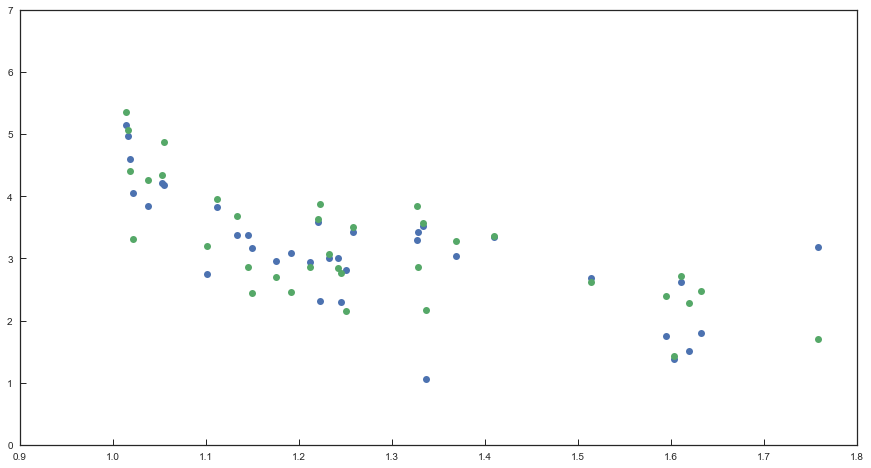

In [15]:
%matplotlib inline

plt.figure(figsize=[15,8])
plt.plot(galDB['hi_res_specz'],Ts,'o')
plt.plot(galDB['hi_res_specz'],galDB['tx_f'],'o')
plt.ylim(0,7)
plt.xlim(0.9,1.8)
plt.show()
plt.close()

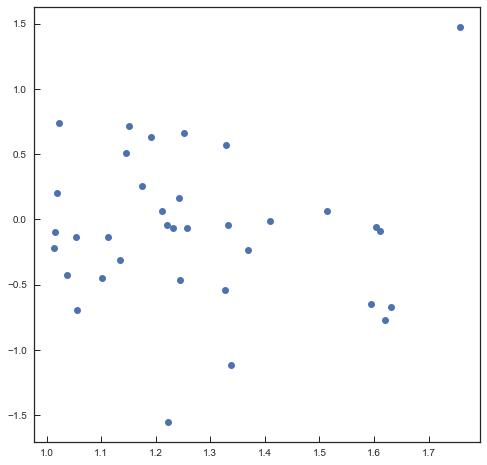

In [21]:
plt.figure(figsize=[8,8])
plt.plot(galDB['hi_res_specz'],Ts-galDB['tx_f'],'o')
plt.show()
plt.close()

In [45]:
"""age DATA"""
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
mzDB = mzDB.query('ids != 14713 and ids != 38126')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

Pl,Pm,Ph,Puh = np.ones([4,len(age)])

for i in lzDB.index:
    P,PZ,PT=Analyze_LH('../chidat/%s_feat_chidata.npy' % lzDB['gids'][i],lzDB['hi_res_specz'][i],metal,age,tau)
    Pl = Pl * PT

for i in mzDB.index:
    P,PZ,PT=Analyze_LH('../chidat/%s_feat_chidata.npy' % mzDB['gids'][i],mzDB['hi_res_specz'][i],metal,age,tau)
    Pm = Pm * PT
    
for i in hzDB.index:
    P,PZ,PT=Analyze_LH('../chidat/%s_feat_chidata.npy' % hzDB['gids'][i],hzDB['hi_res_specz'][i],metal,age,tau)
    Ph = Ph * PT
    
for i in uhzDB.index:
    P,PZ,PT=Analyze_LH('../chidat/%s_feat_chidata.npy' % uhzDB['gids'][i],uhzDB['hi_res_specz'][i],metal,age,tau)
    Puh = Puh * PT
    
Pl /= np.trapz(Pl,age)
Pm /= np.trapz(Pm,age)
Ph /= np.trapz(Ph,age)
Puh /= np.trapz(Puh,age)

lmed,ller,lher=Median_w_Error_cont(Pl,age)
mmed,mler,mher=Median_w_Error_cont(Pm,age)
hmed,hler,hher=Median_w_Error_cont(Ph,age)
uhmed,uhler,uhher=Median_w_Error_cont(Puh,age)

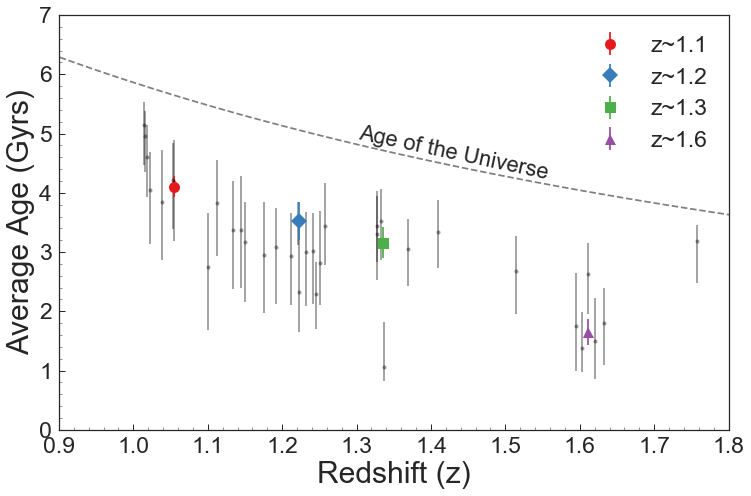

In [46]:
###PLOT
%matplotlib inline

z=np.linspace(0,2,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[12,8])
currentAxis = plt.gca()
plt.plot(z,ages,'k--',alpha=.5)

# plt.errorbar(lzDB['hi_res_specz'],lt,yerr=[lzDB['tx_-_sig_f'],lzDB['tx_+_sig_f']],color='#e41a1c',alpha=.4,ms=4,fmt='o')
# plt.errorbar(mzDB['hi_res_specz'],mt,yerr=[mzDB['tx_-_sig_f'],mzDB['tx_+_sig_f']],color='#377eb8',alpha=.4,ms=4,fmt='o')
# plt.errorbar(hzDB['hi_res_specz'],ht,yerr=[hzDB['tx_-_sig_f'],hzDB['tx_+_sig_f']],color='#4daf4a',alpha=.4,ms=4,fmt='o')
# plt.errorbar(uhzDB['hi_res_specz'],uht,yerr=[uhzDB['tx_-_sig_f'],uhzDB['tx_+_sig_f']],color='#984ea3',alpha=.4,ms=4,fmt='o')
plt.errorbar(galDB['hi_res_specz'],Ts,yerr=[Tel,Teh],color='k',alpha=.4,ms=4,fmt='o')
# plt.plot(galDB['hi_res_specz'],Ts,'ko')

plt.errorbar(np.median(lzDB['hi_res_specz']),lmed,yerr=[[ller,lher]], color='#e41a1c',ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['hi_res_specz']),mmed,yerr=[[mler,mher]], color='#377eb8',ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['hi_res_specz']),hmed,yerr=[[hler,hher]], color='#4daf4a',ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['hi_res_specz']),uhmed,yerr=[[uhler,uhher]], color='#984ea3',ms=11,fmt='^',label='z~1.6')

plt.axis([0.9,1.8,0,7])
plt.xlabel('Redshift (z)',size=30)
plt.ylabel('Average Age (Gyrs)',size=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.text(1.3,4.9,'Age of the Universe',rotation=-12,fontsize=22)
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=23)
plt.show()
plt.close()

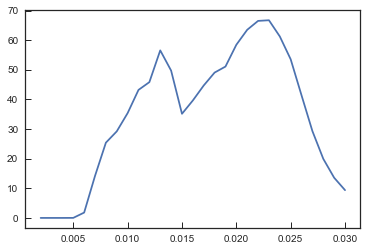

In [12]:
%matplotlib inline
plt.plot(metal,Pm)

In [6]:
"""metal DATA"""
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
mzDB = mzDB.query('ids != 14713 and ids != 38126')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

Pl,Pm,Ph,Puh = np.ones([4,len(metal)])

for i in lzDB.index:
    P,PZ,PT=Analyze_LH('../chidat/%s_feat_chidata.npy' % lzDB['gids'][i],lzDB['hi_res_specz'][i],metal,age,tau)
    Pl = Pl * PZ

for i in mzDB.index:
    P,PZ,PT=Analyze_LH('../chidat/%s_feat_chidata.npy' % mzDB['gids'][i],mzDB['hi_res_specz'][i],metal,age,tau)
    Pm = Pm * PZ
    
for i in hzDB.index:
    P,PZ,PT=Analyze_LH('../chidat/%s_feat_chidata.npy' % hzDB['gids'][i],hzDB['hi_res_specz'][i],metal,age,tau)
    Ph = Ph * PZ
    
for i in uhzDB.index:
    P,PZ,PT=Analyze_LH('../chidat/%s_feat_chidata.npy' % uhzDB['gids'][i],uhzDB['hi_res_specz'][i],metal,age,tau)
    Puh = Puh * PZ
    
Pl /= np.trapz(Pl,metal)
Pm /= np.trapz(Pm,metal)
Ph /= np.trapz(Ph,metal)
Puh /= np.trapz(Puh,metal)

lmed,ller,lher=Median_w_Error_cont(Pl,metal)
mmed,mler,mher=Median_w_Error_cont(Pm,metal)
hmed,hler,hher=Median_w_Error_cont(Ph,metal)
uhmed,uhler,uhher=Median_w_Error_cont(Puh,metal)

logm,gmetal=Readfile('../data/Gallazzi_12.dat',0)
cvx,cvy=Readfile('../data/Gallazzi_12_line.dat',0)
cv1x,cv1y=Readfile('../data/gallazzi_points_curve1.dat',0)

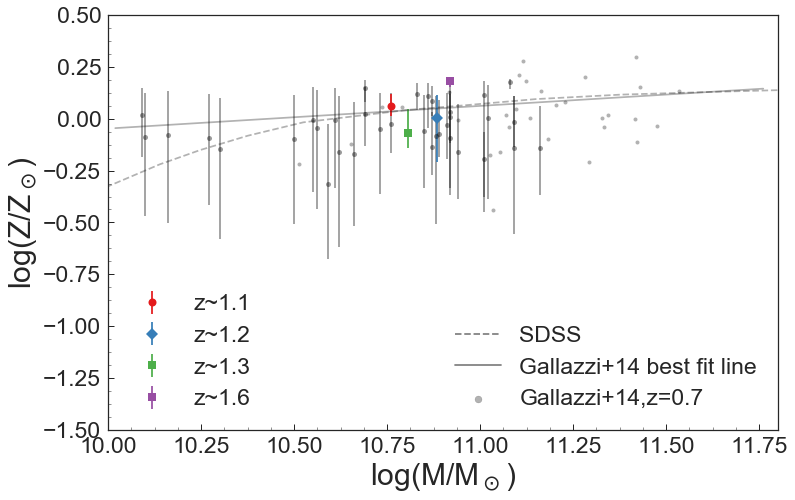

In [50]:
###PLOT
%matplotlib inline

plt.figure(figsize=[12,8])
currentAxis = plt.gca()

####gallazzi points
plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.3,markersize=4)
sdss=plt.axhline(y=5,linestyle='--',color='k',alpha=.5)
plt.plot(cvx,cvy,zorder=2,color='k',alpha=.3,ms=4)
galbf=plt.axhline(y=5,color='k',alpha=.5)
plt.plot(logm,gmetal,'o',zorder=3,color='k',alpha=.3,markersize=4)
galpts = plt.scatter(100,100,marker='o',zorder=3,color='k',alpha=.3)#,label='Gallazzi+14,z=0.7')
legend1 = plt.legend([sdss,galbf,galpts],['SDSS','Gallazzi+14 best fit line','Gallazzi+14,z=0.7'],loc = 4,fontsize=23)
currentAxis.add_artist(legend1)
#####single galaxy points

# plt.errorbar(lzDB['lmass'],np.log10(lZ/0.019), yerr=np.log10([(lzDB['Zx_f']/(lzDB['Zx_f']-lzDB['Zx_-_sig_f'])),
#                             (lzDB['Zx_+_sig_f']/lzDB['Zx_f']+1)]),color='#0D94D5',alpha=.4,ms=5,fmt='o')
# plt.errorbar(mzDB['lmass'],np.log10(mZ/0.019), yerr=np.log10([(mzDB['Zx_f']/(mzDB['Zx_f']-mzDB['Zx_-_sig_f'])),
#                             (mzDB['Zx_+_sig_f']/mzDB['Zx_f']+1)]),color='#B18F3A',alpha=.4,ms=5,fmt='o')
# plt.errorbar(hzDB['lmass'],np.log10(hZ/0.019), yerr=np.log10([(hzDB['Zx_f']/(hzDB['Zx_f']-hzDB['Zx_-_sig_f'])),
#                             (hzDB['Zx_+_sig_f']/hzDB['Zx_f']+1)]),color='#AB3843',alpha=.4,ms=5,fmt='o')
# plt.errorbar(uhzDB['lmass'],np.log10(uhZ/0.019), yerr=np.log10([(uhzDB['Z']/(uhzDB['Z']-uhzDB['Z_-_sig'])),
#                             (uhzDB['Z_+_sig']/uhzDB['Z']+1)]),color='#2AA104',alpha=.4,ms=5,fmt='o')
plt.errorbar(galDB['lmass'],np.log10(np.array(Zs)/0.019), yerr=np.log10([(np.array(Zs)/(np.array(Zs)-np.array(Zel))),
                            (np.array(Zeh)/np.array(Zs)+1)]),color='k',alpha=.4,ms=5,fmt='o')

plt.errorbar(np.median(lzDB['lmass']),np.log10(lmed/0.019), yerr=np.log10([[lmed/(lmed-ller)],[lher/lmed+1]]),
             color='#e41a1c',ms=8,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['lmass']),np.log10(mmed/0.019),  yerr=np.log10([[mmed/(mmed-mler)],[mher/mmed+1]]),
             color='#377eb8',ms=8,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['lmass']),np.log10(hmed/0.019),  yerr=np.log10([[hmed/(hmed-hler)],[hher/hmed+1]]),
             color='#4daf4a',ms=8,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['lmass']),np.log10(uhmed/0.019), yerr=np.log10([[uhmed/(uhmed-uhler)],[uhher/uhmed+1]]),
             color='#984ea3',ms=8,fmt='s',label='z~1.6')


plt.xlabel('log(M/M$_\odot$)',size=30)
plt.ylabel('log(Z/Z$_\odot$)',size=30)
plt.axis([10,11.8,-1.5,.5])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=23)
plt.show()
plt.close()